# Part 1 - classification of crimes into two classes - severe or not severe

As defined above, we can categorize some crime types as "severe" while others as "not severe". As a starting point for classifying crime types, we will start by classifying whether a crime is severe or not.

In [170]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

In [171]:
data_large=pd.read_csv("chicago_final_clean.csv")

In [312]:
#For most algorithms, it will be hard to start from the whole dataframe (1.3 million records).
#As a result, we will sample 5% of the record out and test different algorithms.
data=data_large.sample(60000)
data.shape

(60000, 121)

We will first drop columns we are not using. Though there are many features in this dataset, some information may not be useful at least for now, such as ID, FBI code and Block. Some features are overlapping with each other (such as ward, community area and district), and we will only keep one for simplicity (which also prevents us from including 100% correlated features, which can be bad for regression-based methods).

For the exact coordinates, we will just keep the longitude and latitude data and throw away other things.

In [313]:
data=data.drop(["ID","Date","Block","IUCR","Description","Ward","Community Area","FBI Code"], axis=1)
data=data.drop(["X Coordinate","Y Coordinate","Year","Location","District","Primary Type","time_24hour","Date_no_time"], axis=1)

Note that we are now predicting severe or not, so we will throw away the exact crime type for now. We will also break the "Location Description" into dummy (indicator) variable, a step that we forgot in our data cleanup part... We will also need to drop the "other" description for location because it's ambiguous.

In [314]:
a=list(data.columns.values)
droplist=[]
for i in a:
    if i.startswith("Primary Type"):
        droplist.append(i)
data=data.drop(droplist, axis=1)

There are six features required normalization: Latitude, Longitude, closest_station, TMAX, TMIN, precipitation. Other features for our dataset are all categorical data and have all been converted to dummy variables (District, Time_block, Weekday, Location description, specific weather type). We will split the data into training set and test set, and normalize by themselves (to avoid contamination).

In [315]:
#Reference: hw3
#split test and training set
from sklearn.cross_validation import train_test_split
itrain, itest = train_test_split(xrange(data.shape[0]), train_size=0.7)
mask=np.ones(data.shape[0], dtype='int')
mask[itrain]=1
mask[itest]=0
mask=(mask==1)

In [316]:
print data.shape
data.head()

(60000, 81)


,Latitude,Longitude,severe,District_D1.0,District_D10.0,District_D11.0,District_D12.0,District_D14.0,District_D15.0,District_D16.0,District_D17.0,District_D18.0,District_D19.0,District_D2.0,District_D20.0,District_D22.0,District_D24.0,District_D25.0,District_D3.0,District_D4.0,District_D5.0,District_D6.0,District_D7.0,District_D8.0,District_D9.0,Timeblock_0,Timeblock_12,Timeblock_15,Timeblock_18,Timeblock_21,Timeblock_3,Timeblock_6,Timeblock_9,Weekday_Friday,Weekday_Monday,Weekday_Saturday,Weekday_Sunday,Weekday_Thursday,Weekday_Tuesday,Weekday_Wednesday,Precipitation,TMAX,TMIN,WT01,WT05,WT02,WT08,WT03,WT10,closest_station,House_crowded,House_below_poverty,Unemployed,Without_high_school,Under18_over64,Income,Hardship,Location Description_ALLEY,Location Description_APARTMENT,Location Description_BAR OR TAVERN,Location Description_COMMERCIAL / BUSINESS OFFICE,Location Description_CTA BUS,Location Description_CTA PLATFORM,Location Description_CTA TRAIN,Location Description_DEPARTMENT STORE,Location Description_GAS STATION,Location Description_GROCERY FOOD STORE,Location Description_PARK PROPERTY,Location Description_PARKING LOT/GARAGE(NON.RESID.),Location Description_RESIDENCE,Location Description_RESIDENCE PORCH/HALLWAY,Location Description_RESIDENCE-GARAGE,Location Description_RESIDENTIAL YARD (FRONT/BACK),Location Description_RESTAURANT,"Location Description_SCHOOL, PUBLIC, BUILDING","Location Description_SCHOOL, PUBLIC, GROUNDS",Location Description_SIDEWALK,Location Description_SMALL RETAIL STORE,Location Description_STREET,Location Description_VACANT LOT/LAND,Location Description_VEHICLE NON-COMMERCIAL
1092021,41.802971,-87.663750,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,30.6,21.7,0,0,0,0,0,0,1.609154,11.9,29.0,23.0,41.5,38.9,12765,91,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
54299,41.749985,-87.560833,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,43,32.2,21.1,0,0,0,0,0,0,2.589948,4.7,29.8,19.7,26.6,41.1,16579,75,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1029741,41.926993,-87.785722,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,15.6,8.9,0,0,0,0,0,0,1.235018,10.8,18.7,14.6,37.3,37.3,15461,70,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
552677,41.738268,-87.640175,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,23.3,10.0,0,0,0,0,0,0,0.978169,4.0,27.6,28.3,18.5,41.9,15528,74,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
524936,41.881017,-87.711989,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,31.1,22.8,0,0,0,0,0,0,0.620211,8.2,42.4,19.6,21.3,43.2,12961,83,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [317]:
#We have a list of continuous features, or in other words standardizable variables
STANDARDIZABLE=["Latitude", 'Longitude',"closest_station",'TMAX',"TMIN","Precipitation","House_crowded","House_below_poverty","Unemployed","Without_high_school","Under18_over64","Income","Hardship"]

#Also create a list for indicator variable. We can do this by excluding the above continuous features from total features. 
INDICATOR=list(data.columns)
#We need to remove the response variable from our total list of features
INDICATOR.remove(u'severe')
#This is to create a list of indicator variables by excluding the continous features
for i in STANDARDIZABLE:
    INDICATOR.remove(i)
print len(STANDARDIZABLE), len(INDICATOR)

13 67


In [318]:
from sklearn.preprocessing import StandardScaler
#Standardize training set
data.loc[mask,STANDARDIZABLE]=StandardScaler().fit_transform(data.loc[mask,STANDARDIZABLE])
#Standardize test set
data.loc[~mask,STANDARDIZABLE]=StandardScaler().fit_transform(data.loc[~mask,STANDARDIZABLE])

In [319]:
data.head(5)

,Latitude,Longitude,severe,District_D1.0,District_D10.0,District_D11.0,District_D12.0,District_D14.0,District_D15.0,District_D16.0,District_D17.0,District_D18.0,District_D19.0,District_D2.0,District_D20.0,District_D22.0,District_D24.0,District_D25.0,District_D3.0,District_D4.0,District_D5.0,District_D6.0,District_D7.0,District_D8.0,District_D9.0,Timeblock_0,Timeblock_12,Timeblock_15,Timeblock_18,Timeblock_21,Timeblock_3,Timeblock_6,Timeblock_9,Weekday_Friday,Weekday_Monday,Weekday_Saturday,Weekday_Sunday,Weekday_Thursday,Weekday_Tuesday,Weekday_Wednesday,Precipitation,TMAX,TMIN,WT01,WT05,WT02,WT08,WT03,WT10,closest_station,House_crowded,House_below_poverty,Unemployed,Without_high_school,Under18_over64,Income,Hardship,Location Description_ALLEY,Location Description_APARTMENT,Location Description_BAR OR TAVERN,Location Description_COMMERCIAL / BUSINESS OFFICE,Location Description_CTA BUS,Location Description_CTA PLATFORM,Location Description_CTA TRAIN,Location Description_DEPARTMENT STORE,Location Description_GAS STATION,Location Description_GROCERY FOOD STORE,Location Description_PARK PROPERTY,Location Description_PARKING LOT/GARAGE(NON.RESID.),Location Description_RESIDENCE,Location Description_RESIDENCE PORCH/HALLWAY,Location Description_RESIDENCE-GARAGE,Location Description_RESIDENTIAL YARD (FRONT/BACK),Location Description_RESTAURANT,"Location Description_SCHOOL, PUBLIC, BUILDING","Location Description_SCHOOL, PUBLIC, GROUNDS",Location Description_SIDEWALK,Location Description_SMALL RETAIL STORE,Location Description_STREET,Location Description_VACANT LOT/LAND,Location Description_VEHICLE NON-COMMERCIAL
1092021,-0.431047,0.142077,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,-0.034025,1.173342,1.324055,0,0,0,0,0,0,0.599076,1.714176,0.384426,0.749531,1.766888,0.457929,-0.679162,1.204962,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
54299,-1.048587,1.919419,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0.089122,1.311058,1.266829,0,0,0,0,0,0,2.139896,-0.197213,0.462775,0.321431,0.465556,0.737611,-0.465028,0.661049,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1029741,1.014436,-1.964330,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,-0.034025,-0.117748,0.103237,0,0,0,0,0,0,0.011312,1.422158,-0.624316,-0.340178,1.400070,0.254523,-0.527797,0.491076,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
552677,-1.190706,0.556174,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,-0.041302,0.545486,0.208644,0,0,0,0,0,0,-0.394376,-0.388210,0.248662,1.439215,-0.248301,0.835160,-0.521297,0.623353,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
524936,0.479103,-0.677526,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,-0.041302,1.213926,1.416895,0,0,0,0,0,0,-0.956700,0.726336,1.692919,0.309887,-0.004447,0.999524,-0.665176,0.928720,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


Now we perform exploratory data analysis to see what features can be important. Let's first look at the 6 continuous variable.

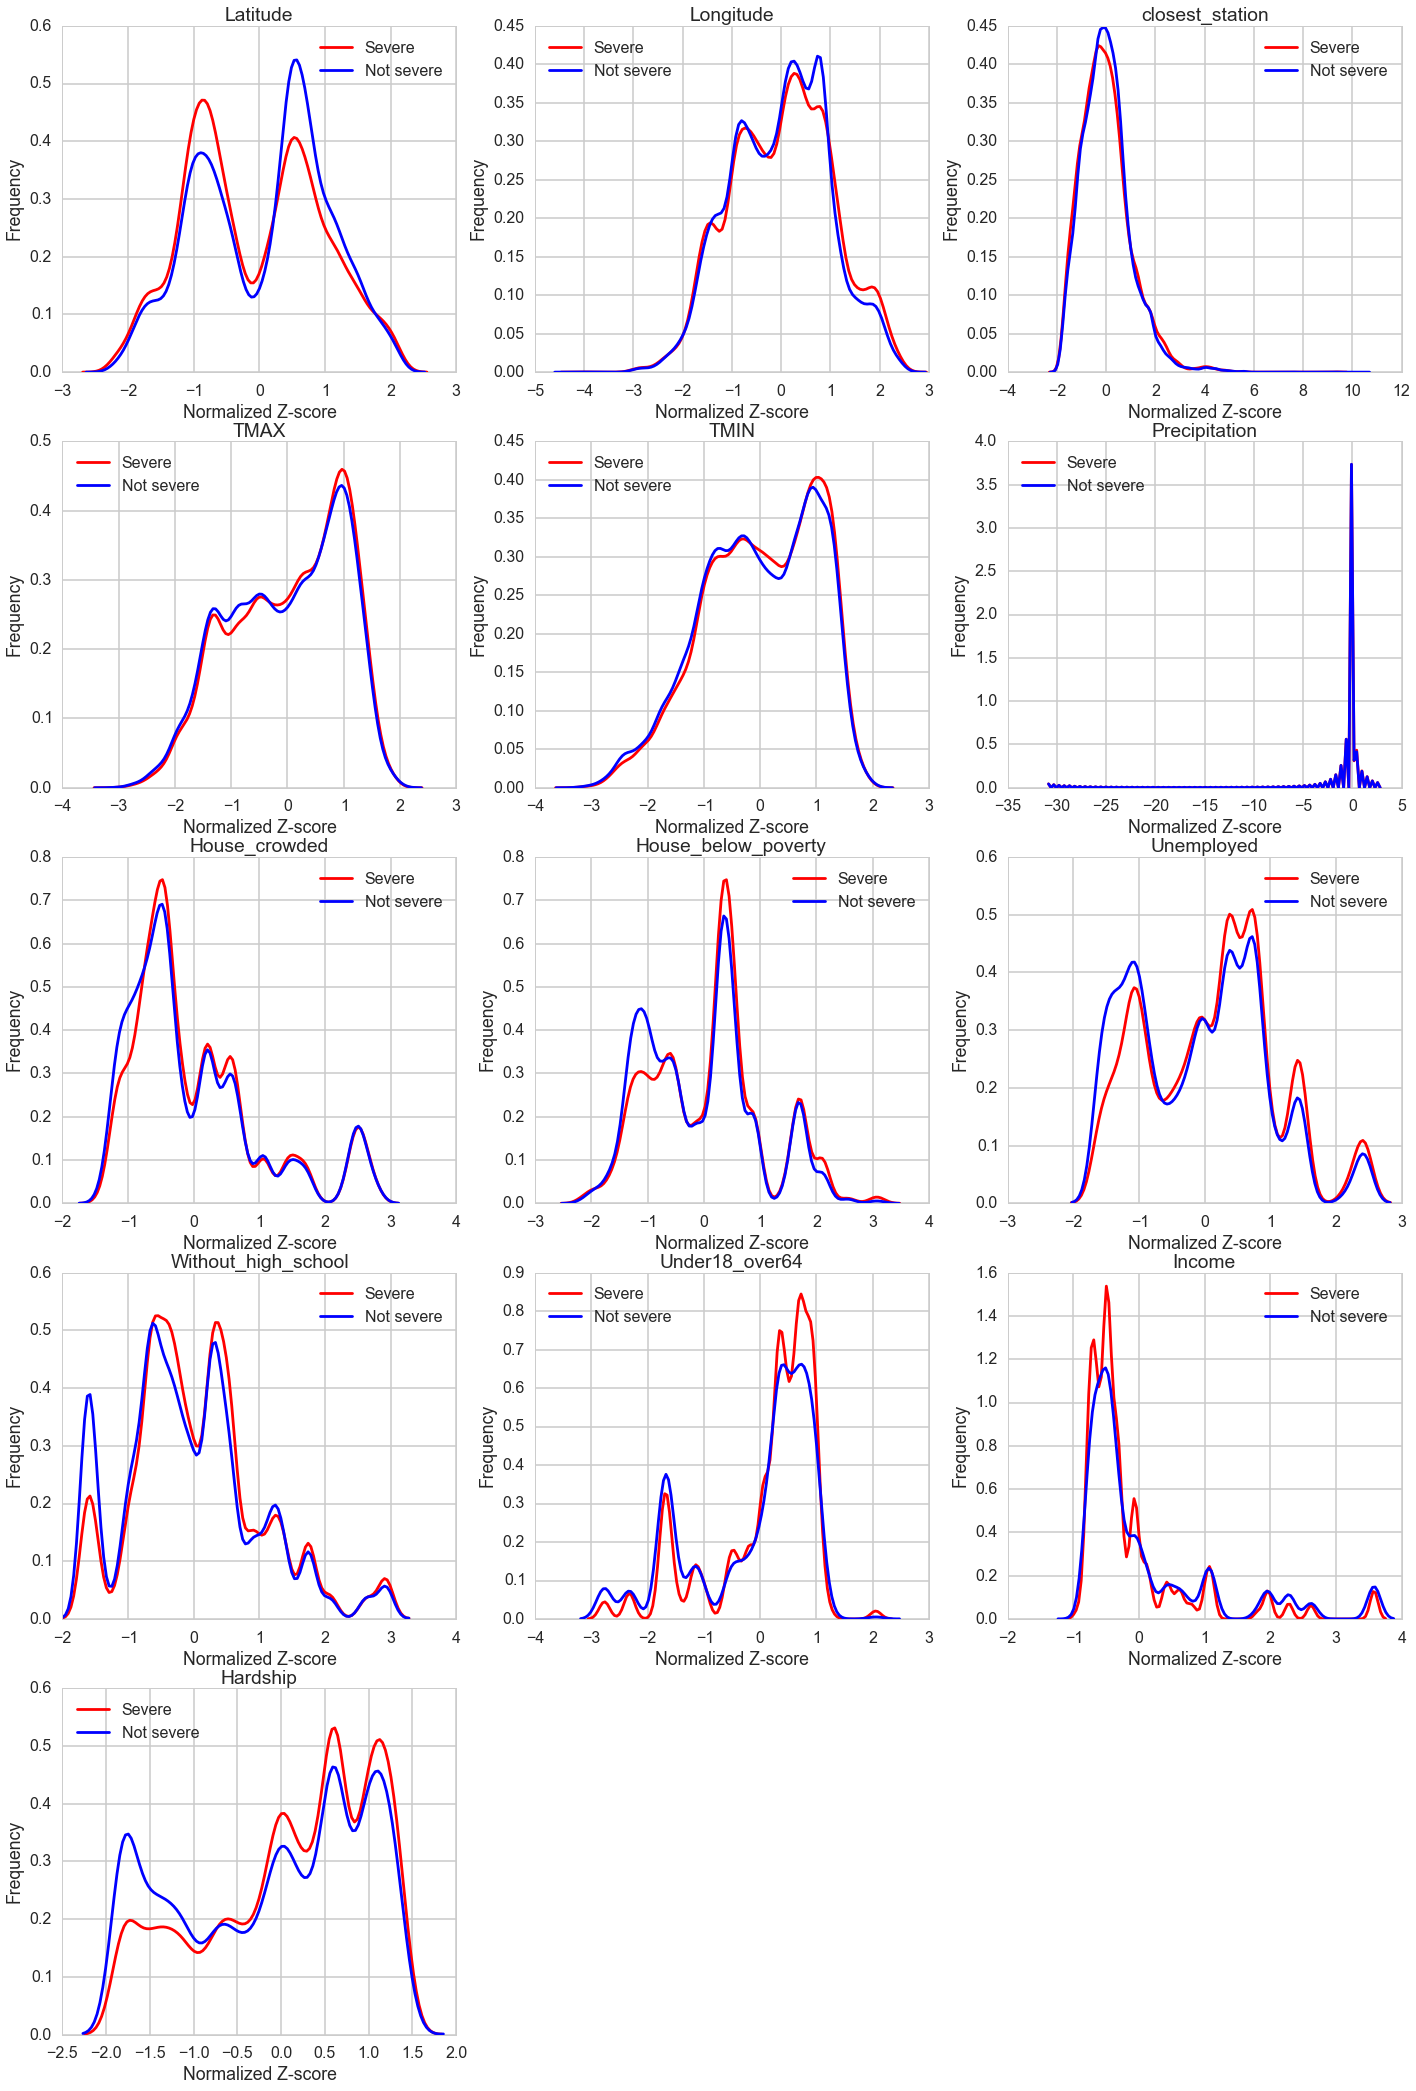

In [320]:
fig=plt.figure(figsize=(24,36))
pos=data[data["severe"]==1]
neg=data[data["severe"]==0]
for k in range (13):
    ax=fig.add_subplot(5,3,k+1)    
    sns.kdeplot(pos[STANDARDIZABLE[k]],color="red",label="Severe")
    sns.kdeplot(neg[STANDARDIZABLE[k]],color="blue",label="Not severe")
    ax.set_title(STANDARDIZABLE[k])
    ax.set_xlabel("Normalized Z-score")
    ax.set_ylabel("Frequency")

We can see the latitude and longitude info may be helpful for classification. For example, if the latitude is low, it's more likely that severe crime will happen. This is consistent with the fact that the safety at south Chicago is notoriously bad.

The economic / education / age status we introduce do provide expected result. For example, for regions with lower income and higher unemployment rate, the crimes are going to be more severe.

Some additional features we introduce, such as temperature and distance to closest station, seems to have some effects in the directions we expected, but not very strong. The mild effect can be explained by either the effect is indeed small, or the way we categorize the crimes (severe and non-severe) is not perfect (for example, within "non-severe" crimes, some are more severe than the others, but we can not tell right now).

Looking at all the features, we will see that none of the feature by itself is good enough to predict whether a crime is severe or not. This is simply because we have manually set up a standard for "severe" and "non severe", and this prior classification is not very clear cut and accurate.

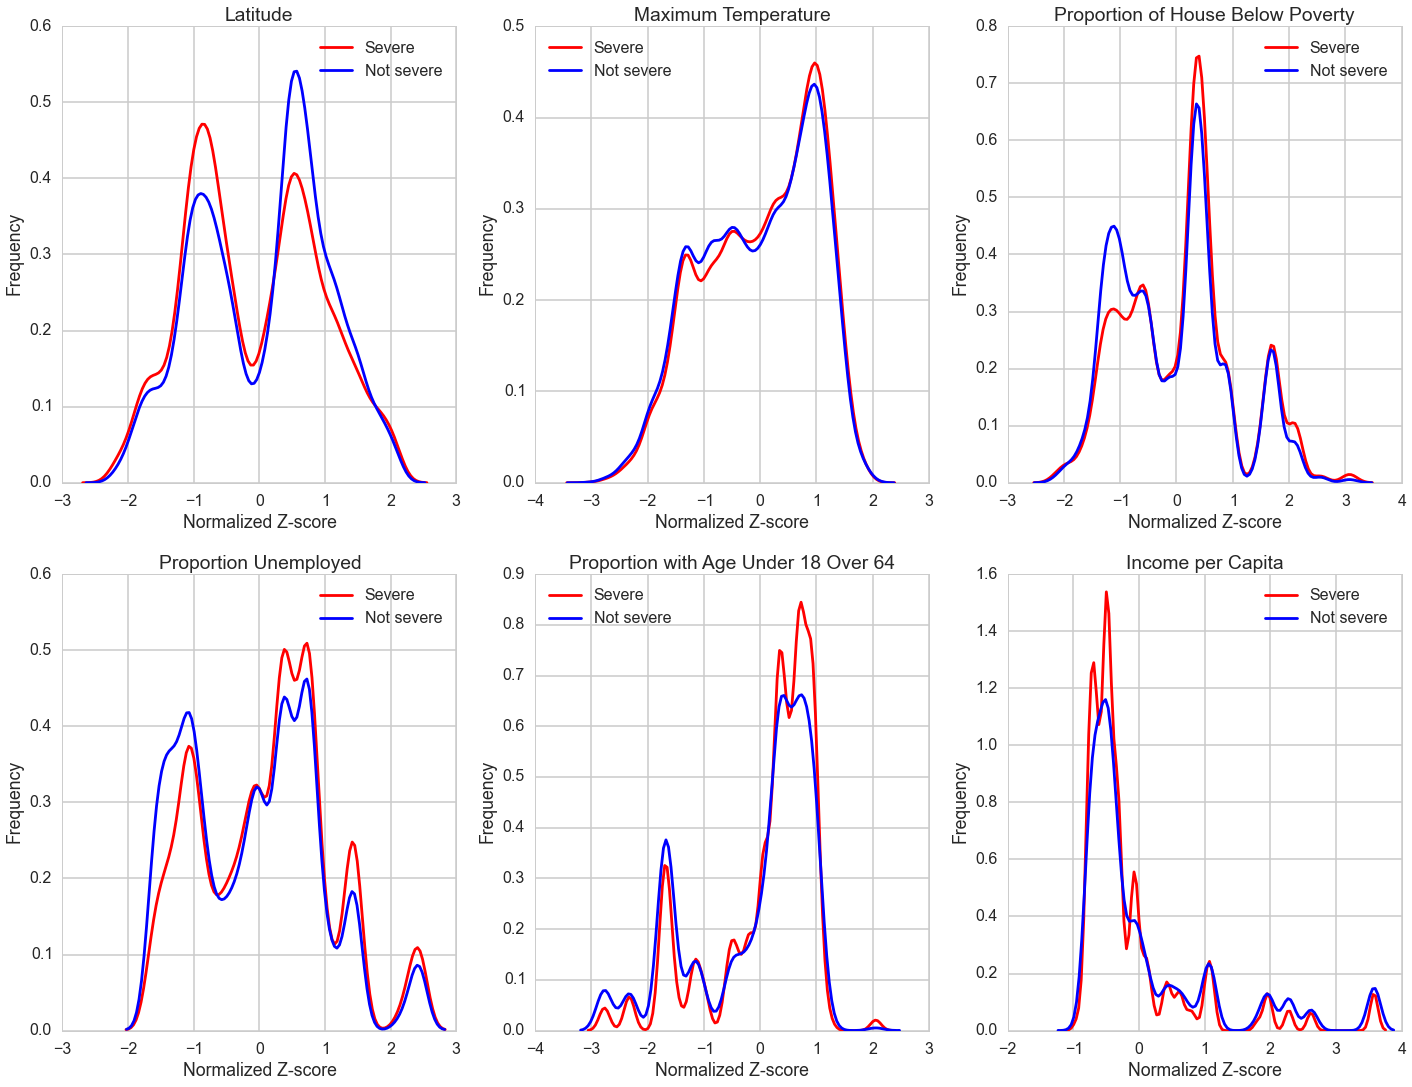

In [321]:
#The following command just plot those continuous features with significant effects (for presentation purpose)
plotlist=["Latitude","TMAX","House_below_poverty","Unemployed","Under18_over64","Income"]
plotlist_title=["Latitude","Maximum Temperature","Proportion of House Below Poverty","Proportion Unemployed", "Proportion with Age Under 18 Over 64", "Income per Capita"]
fig=plt.figure(figsize=(24,18))
for k in range (6):
    ax=fig.add_subplot(2,3,k+1)    
    sns.kdeplot(pos[plotlist[k]],color="red",label="Severe")
    sns.kdeplot(neg[plotlist[k]],color="blue",label="Not severe")
    ax.set_title(plotlist_title[k])
    ax.set_xlabel("Normalized Z-score")
    ax.set_ylabel("Frequency")

Let's explore the 68 indicator variables we have to see whether any of them will be good to judge whether a crime is severe or not.

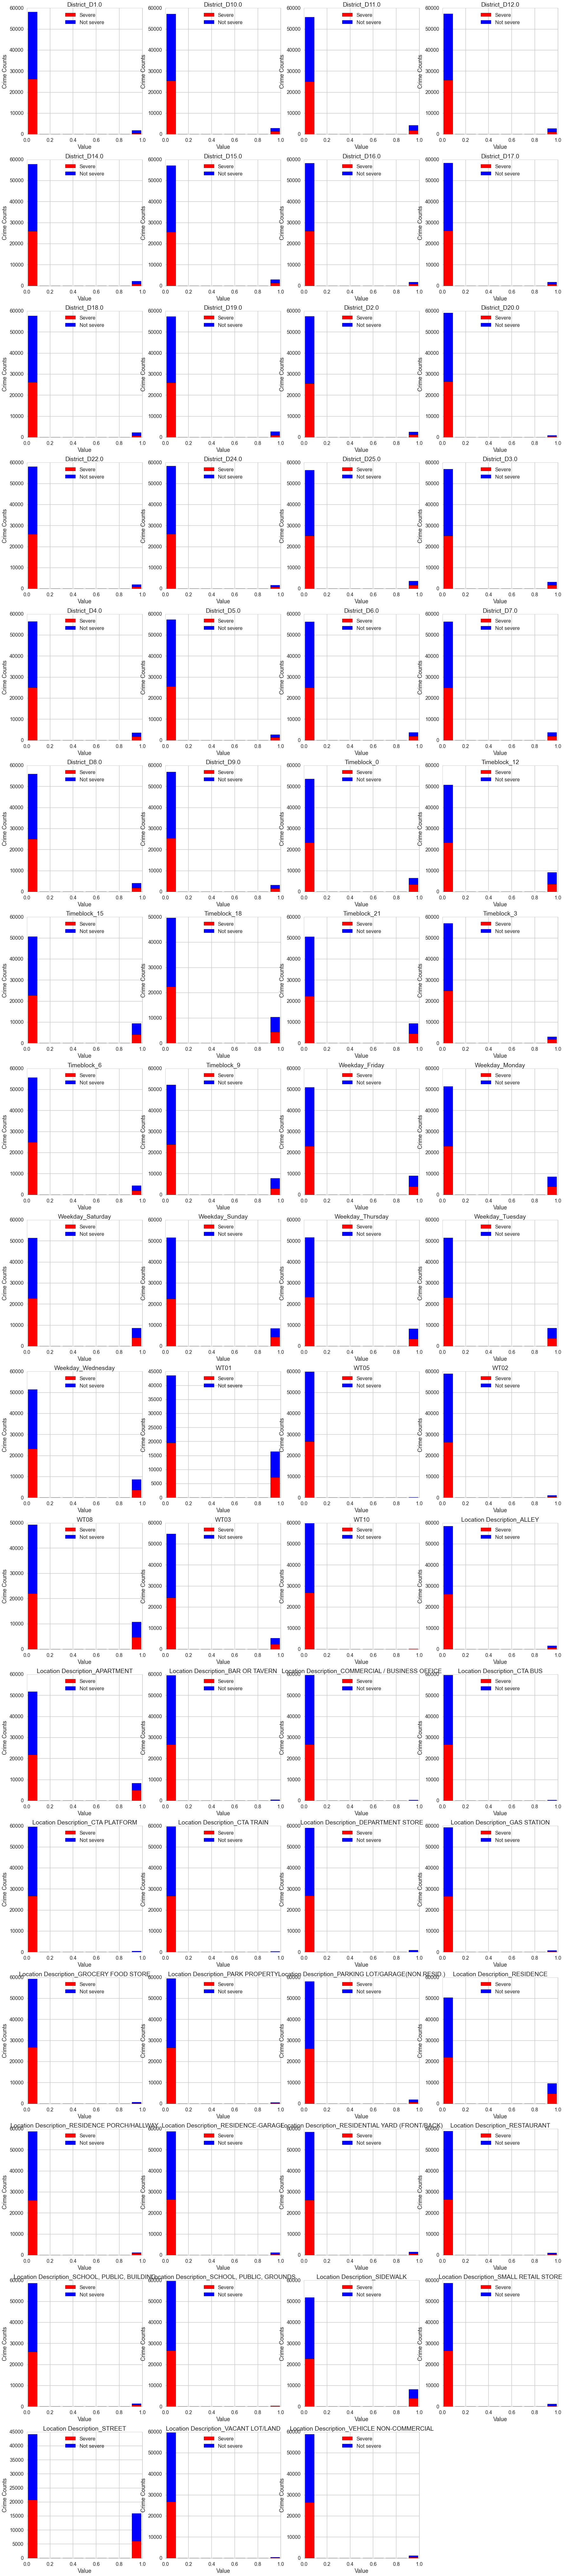

In [322]:
fig=plt.figure(figsize=(30,144))
pos=data[data['severe']==1]
neg=data[data['severe']==0]
for k in range (67):
    ax=fig.add_subplot(17,4,k+1)
    ax.hist((pos[INDICATOR[k]],neg[INDICATOR[k]]),stacked=True,color=("red","blue"),range=[0,1])
    ax.set_title(INDICATOR[k])
    ax.legend(("Severe","Not severe"),loc="upper center")
    ax.set_xlabel("Value")
    ax.set_ylabel("Crime Counts")

We can see some indicator variables will be good to classify whether a crime is severe or not. For example, if the time block is 0 or 3 (meaning 0 to 3am and 3 to 6am), the proportion of severe crime is obviously higher. If the crime takes place in an apartment or house, it's more likely to be a severe crime (a little bit counter intuitive but also make sense, since breaking into people's residential places usually involves brutal forces and violence towards the victims). If the crime takes place on a street where everyone can see, it's less likely going to be severe, while a crime happening in side walks or alleys is more likely to be a severe one.

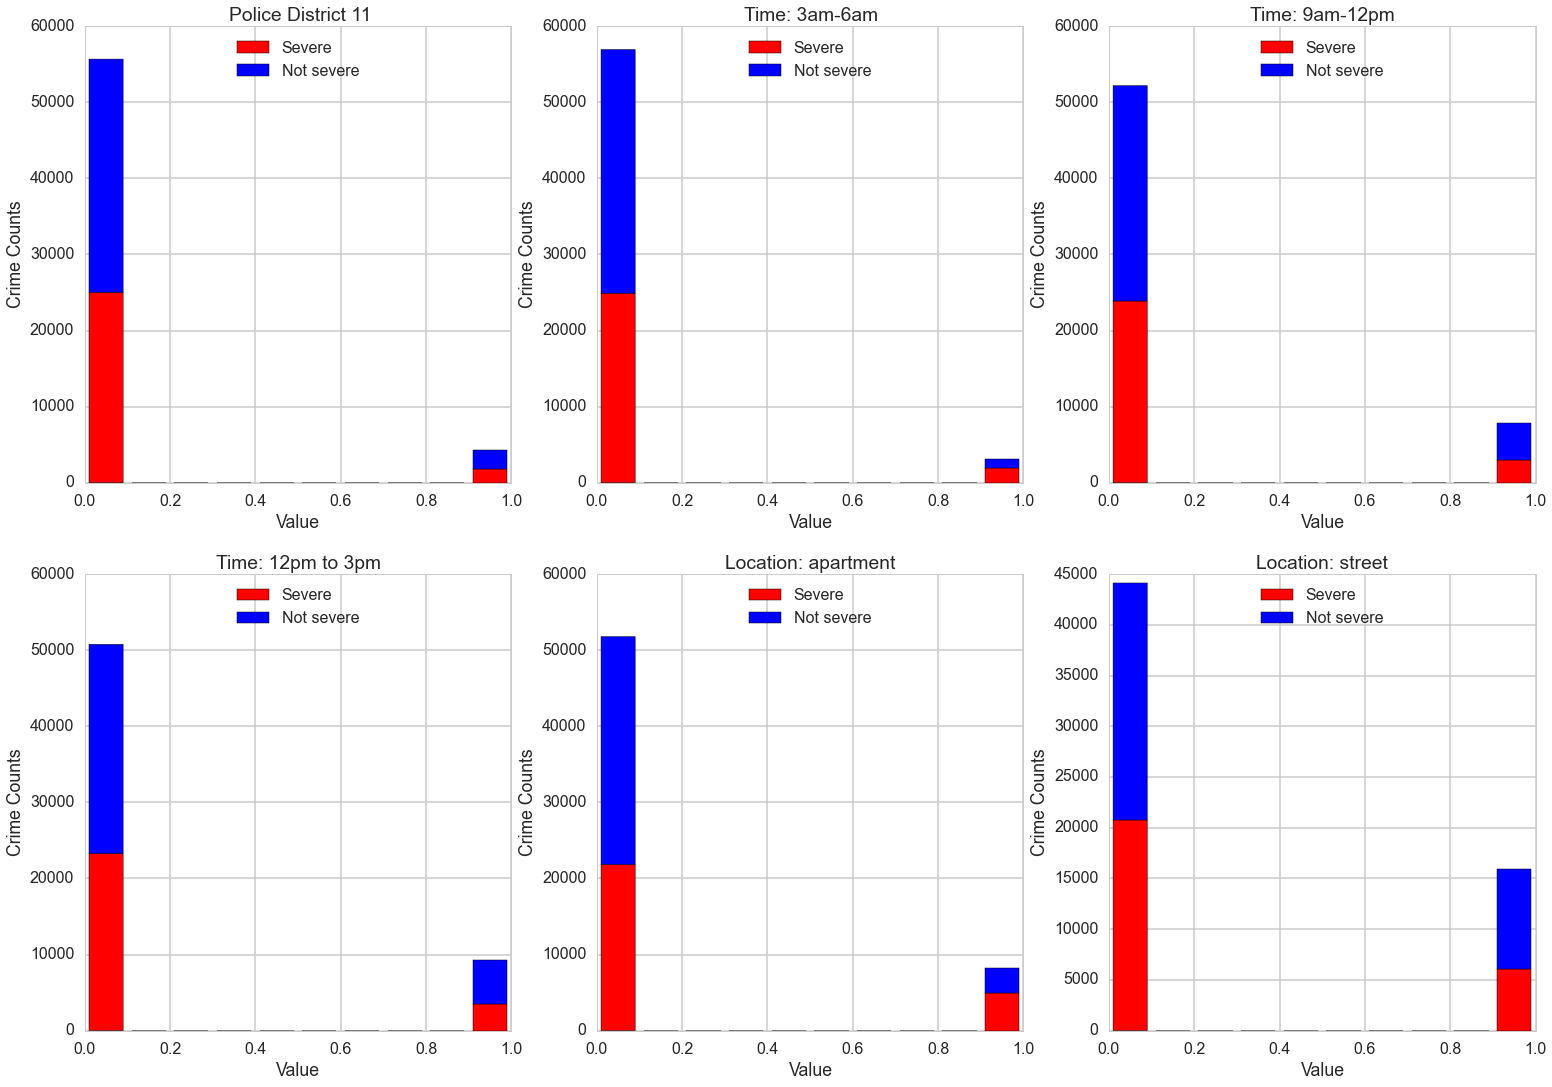

In [323]:
#This cell is to plot those indicator variables that will be good predictor for whether a crime will be severe or not.
fig=plt.figure(figsize=(26,18))
plotfeature=["District_D11.0","Timeblock_3","Timeblock_9","Timeblock_12","Location Description_APARTMENT","Location Description_STREET"]
plotfeature_title=["Police District 11","Time: 3am-6am","Time: 9am-12pm", "Time: 12pm to 3pm","Location: apartment","Location: street"]
for k in range (6):
    ax=fig.add_subplot(2,3,k+1)
    ax.hist((pos[plotfeature[k]],neg[plotfeature[k]]),stacked=True,color=("red","blue"),range=[0,1])
    ax.set_title(plotfeature_title[k])
    ax.legend(("Severe","Not severe"),loc="upper center")
    ax.set_xlabel("Value")
    ax.set_ylabel("Crime Counts")

### Model 0 - Baseline model
For any classification problem, there is always a baseline model: classify everything as the class that occurs most frequently. In our case, the two classes have comparable percentage. The "severe" crime accounts for 46% of the total crime, while the "non_severe" is around 53%. As a result, if we use classification accuracy as the only criteria to judge whether a model is good or not, a good model should at least have the baseline accuracy of 54%.

In [324]:
pos=data[data['severe']==1]
neg=data[data['severe']==0]
percent_severe=float(len(pos))/len(data)
percent_non_severe=float(len(neg))/len(data)
print percent_severe, percent_non_severe

0.446966666667 0.553033333333


In [325]:
#Let's make a dictionary storing confusion matrix for all the algorithms, so that we can have some comparison
confusion_dict={}
confusion_dict["Baseline_model"]=np.asarray([[len(neg),0],[len(pos),0]])
#Also create a dictionary to store all the models
model_dict={}
#The following dict will store the accuracy for training set
accuracy_dict={}
#The following dict will store the accuracy for test set
accuracy_dict1={}
train_not_severe_percent=1-float(sum(data["severe"].values[mask]))/len(data["severe"].values[mask])
test_not_severe_percent=1-float(sum(data["severe"].values[~mask]))/len(data["severe"].values[~mask])
print train_not_severe_percent, test_not_severe_percent 
accuracy_dict["Baseline_model"]=train_not_severe_percent
accuracy_dict1["Baseline_model"]=test_not_severe_percent

0.55330952381 0.552388888889


### Model 1 - Logistic regression with Lasso-based feature selection

In [326]:
#Got the X and y for traning set and test set
total_features=STANDARDIZABLE+INDICATOR

In [327]:
#reference: hw3 do_classify function
#Slightly modify the hw3 function, but overall very similar
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import confusion_matrix
def do_classify(clf, parameters, indf, featurenames, targetname, target1val, mask, score_func=None, n_folds=5):
    subdf=indf[featurenames]
    X=subdf.values
    y=(indf[targetname].values==target1val)*1
    Xtrain, Xtest, ytrain, ytest = X[mask], X[~mask], y[mask], y[~mask]
    if parameters:
        clf = cv_optimize(clf, parameters, Xtrain, ytrain, n_folds=n_folds, score_func=score_func)
    clf=clf.fit(Xtrain, ytrain)
    training_accuracy = clf.score(Xtrain, ytrain)
    test_accuracy = clf.score(Xtest, ytest)
    print "Training accuracy: %0.2f" % (training_accuracy)
    print "Test accuracy:     %0.2f" % (test_accuracy)
    confmatrix=confusion_matrix(ytest, clf.predict(Xtest))
    print confmatrix
    print clf
    return clf, Xtrain, ytrain, Xtest, ytest, confmatrix, training_accuracy, test_accuracy

In [328]:
#reference: hw3 cv_optimize function
#we will use five fold validation by default
#This function is largely the same as the one in our hw
def cv_optimize(clf, parameters, X, y, n_folds=5, score_func=None):
    if score_func:
        gs=GridSearchCV(clf, param_grid=parameters, cv=n_folds, scoring=score_func)
    else:
        gs=GridSearchCV(clf, param_grid=parameters, cv=n_folds)
    gs.fit(X, y)
    best = gs.best_estimator_
    return best

In [329]:
from sklearn.linear_model import LogisticRegression
clflog = LogisticRegression(penalty="l1")
clflog, Xtrain, ytrain, Xtest, ytest, confclflog, training_accuracy, test_accuracy=do_classify(clflog, {"C": [0.001, 0.01, 0.1, 1.0, 10.0, 20.0, 40.0, 70.0, 100.0]}, data, total_features, u'severe', 1, mask=mask)
confusion_dict["Logistic"]=confclflog
model_dict["Logistic"]=clflog
accuracy_dict["Logistic"]=training_accuracy
accuracy_dict1["Logistic"]=test_accuracy

Training accuracy: 0.63
Test accuracy:     0.63
[[7400 2543]
 [4125 3932]]
LogisticRegression(C=40.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0)


In [332]:
#in addition to l2 (lasso) regularization, we also tried l2 regularization (the default mode). It works equally well and seems to run faster.
from sklearn.linear_model import LogisticRegression
clflog2 = LogisticRegression(penalty="l2")
clflog2, Xtrain, ytrain, Xtest, ytest, confclflog2, training_accuracy, test_accuracy=do_classify(clflog2, {"C": [0.001, 0.01, 0.1, 1.0, 10.0, 20.0, 40.0, 70.0, 100.0]}, data, total_features, u'severe', 1, mask=mask)

Training accuracy: 0.63
Test accuracy:     0.63
[[7402 2541]
 [4126 3931]]
LogisticRegression(C=70.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0)


### Model 2 - Linear SVM

In [333]:
from sklearn.svm import LinearSVC
clfsvm=LinearSVC(loss="hinge")
clfsvm, Xtrain, ytrain, Xtest, ytest, confclfsvm, training_accuracy, test_accuracy= do_classify(clfsvm, {"C": [0.001, 0.01, 0.1, 1.0, 10.0, 50, 100.0]}, data, total_features, u'severe',1, mask=mask)
confusion_dict["svm"]=confclfsvm
model_dict["svm"]=clfsvm
accuracy_dict["svm"]=training_accuracy
accuracy_dict1["svm"]=test_accuracy

Training accuracy: 0.60
Test accuracy:     0.60
[[8320 1623]
 [5580 2477]]
LinearSVC(C=0.1, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
     penalty='l2', random_state=None, tol=0.0001, verbose=0)


### Model 3 - Decision tree

In [334]:
from sklearn.tree import DecisionTreeClassifier
clfdt=DecisionTreeClassifier()
clfdt, Xtrain, ytrain, Xtest, ytest, confclfdt, training_accuracy, test_accuracy = do_classify(clfdt, {"max_depth":range(1,20,2)}, data, total_features, u'severe',1, mask=mask)
confusion_dict["decision tree"]=confclfdt
model_dict["decision tree"]=clfdt
accuracy_dict["decision tree"]=training_accuracy
accuracy_dict1["decision tree"]=test_accuracy

Training accuracy: 0.66
Test accuracy:     0.62
[[8006 1937]
 [4825 3232]]
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=11,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            random_state=None, splitter='best')


### Model 4 - Naive Bayes model

In [335]:
from sklearn.naive_bayes import GaussianNB
clfgnb = GaussianNB()
clfgnb, Xtrain, ytrain, Xtest, ytest, confgnb, training_accuracy, test_accuracy=do_classify(clfgnb, None, data, total_features, u'severe',1, mask=mask)
confusion_dict["Naive Bayes"]=confgnb
model_dict["Naive Bayes"]=clfgnb
accuracy_dict["Naive Bayes"]=training_accuracy
accuracy_dict1["Naive Bayes"]=test_accuracy

Training accuracy: 0.55
Test accuracy:     0.55
[[3418 6525]
 [1577 6480]]
GaussianNB()


### Model 5 - Random forest

In [336]:
from sklearn.ensemble import RandomForestClassifier
randf=RandomForestClassifier()
clfrdf, Xtrain, ytrain, Xtest, ytest, confrdf, training_accuracy, test_accuracy=do_classify(randf, {"n_estimators":[10, 20, 30, 40, 100]}, data, total_features, u'severe',1, mask=mask)
confusion_dict["Random forest"]=confrdf
model_dict["Random forest"]=clfrdf
accuracy_dict["Random forest"]=training_accuracy
accuracy_dict1["Random forest"]=test_accuracy

Training accuracy: 1.00
Test accuracy:     0.62
[[7303 2640]
 [4221 3836]]
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


### Model 6 - KNN

In [338]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier()
neigh, Xtrain1, ytrain1, Xtest1, ytest1, confknn, training_accuracy, test_accuracy=do_classify(neigh, {"n_neighbors":[5, 10, 20, 40]}, data, total_features, u'severe',1, mask=mask)
confusion_dict["KNN"]=confknn
model_dict["KNN"]=neigh
accuracy_dict["KNN"]=training_accuracy
accuracy_dict1["KNN"]=test_accuracy

Training accuracy: 0.63
Test accuracy:     0.59
[[7661 2282]
 [5019 3038]]
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_neighbors=40, p=2, weights='uniform')


### Model 7 - Ada Boost

In [339]:
from sklearn.ensemble import AdaBoostClassifier
ada = AdaBoostClassifier()
ada, Xtrain, ytrain, Xtest, ytest, confada, training_accuracy, test_accuracy=do_classify(ada, {"n_estimators":[30, 50, 100]}, data, total_features, u'severe',1, mask=mask)
confusion_dict["Ada Boost"]=confada
model_dict["Ada Boost"]=ada
accuracy_dict["Ada Boost"]=training_accuracy
accuracy_dict1["Ada Boost"]=test_accuracy

Training accuracy: 0.63
Test accuracy:     0.63
[[7336 2607]
 [4119 3938]]
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=100, random_state=None)


To sum up, the following models work almost equally well (none is perfect):
Logistic regression with lasso-based feature selection, decision tree, random forest and ada boost. We will now visualize through ROC curve how all the models performed. We will also compare the confusion matrix from all the models.

### Check the ROC curve for different algorithms
Note that we cannot draw ROC curve for tree-based algorithms, since they only provide us with the final outcome of the classification.

In [340]:
#REFERENCE: The following code are from hw3 and lab
from sklearn.metrics import roc_curve, auc
def make_roc(name, clf, ytest, xtest, ax=None, labe=5, proba=True, skip=0):
    initial=False
    if not ax:
        ax=plt.gca()
        initial=True
    if proba:#for stuff like logistic regression
        fpr, tpr, thresholds=roc_curve(ytest, clf.predict_proba(xtest)[:,1])
    else:#for stuff like SVM
        fpr, tpr, thresholds=roc_curve(ytest, clf.decision_function(xtest))
    roc_auc = auc(fpr, tpr)
    if skip:
        l=fpr.shape[0]
        ax.plot(fpr[0:l:skip], tpr[0:l:skip], '.-', alpha=0.3, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    else:
        ax.plot(fpr, tpr, '.-', alpha=0.3, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    label_kwargs = {}
    label_kwargs['bbox'] = dict(
        boxstyle='round,pad=0.3', alpha=0.2,
    )
    if labe!=None:
        for k in xrange(0, fpr.shape[0],labe):
            #from https://gist.github.com/podshumok/c1d1c9394335d86255b8
            threshold = str(np.round(thresholds[k], 2))
            ax.annotate(threshold, (fpr[k], tpr[k]), **label_kwargs)
    if initial:
        ax.plot([0, 1], [0, 1], 'k--')
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title('ROC')
    ax.legend(loc="lower right")
    return ax

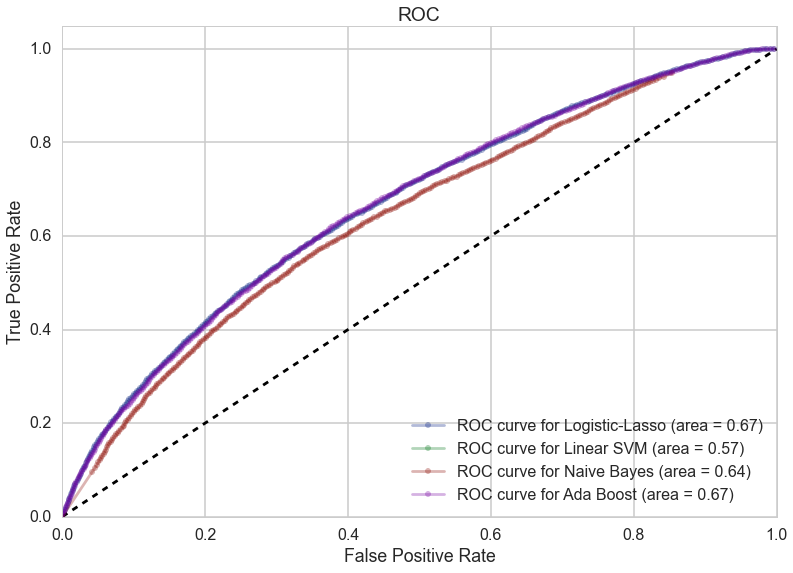

In [341]:
#Compare ROC curve - Figure 1
#Note that not all algorithms support ROC curve
#Reference: hw3
with sns.color_palette("dark"):
    ax=make_roc("Logistic-Lasso",clflog, ytest, Xtest, None, labe=None, proba=True, skip=50);
    make_roc("Linear SVM",clfsvm, ytest, Xtest, ax, labe=None, proba=False, skip=50);
    make_roc("Naive Bayes",clfgnb, ytest, Xtest, ax, labe=None, proba=True,  skip=50);
    make_roc("Ada Boost",ada, ytest, Xtest, ax, labe=None, proba=True,  skip=50);

### Compare testing accuracy

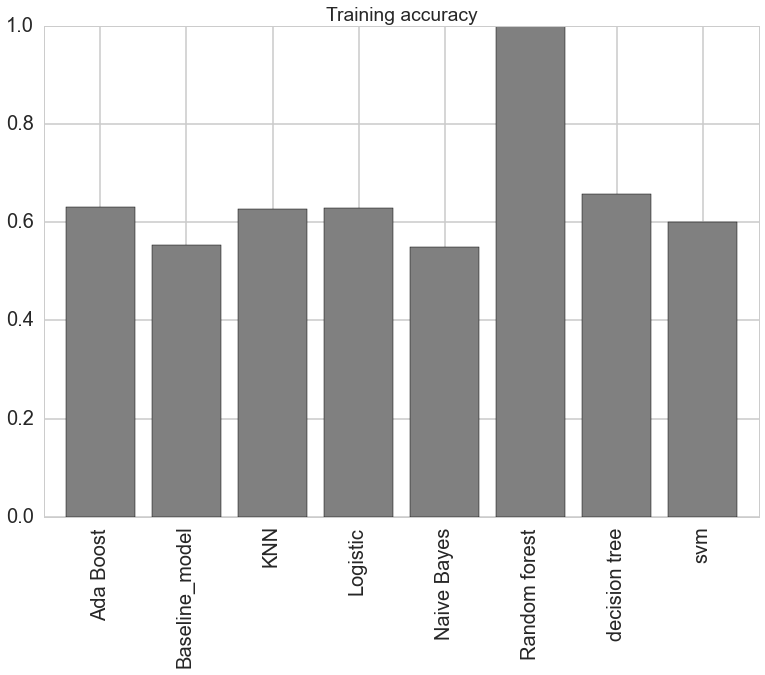

In [342]:
#Compare training and testing accuracy
pd.Series(accuracy_dict).plot(kind="bar",title="Training accuracy",width=0.8,color="grey", fontsize=20)

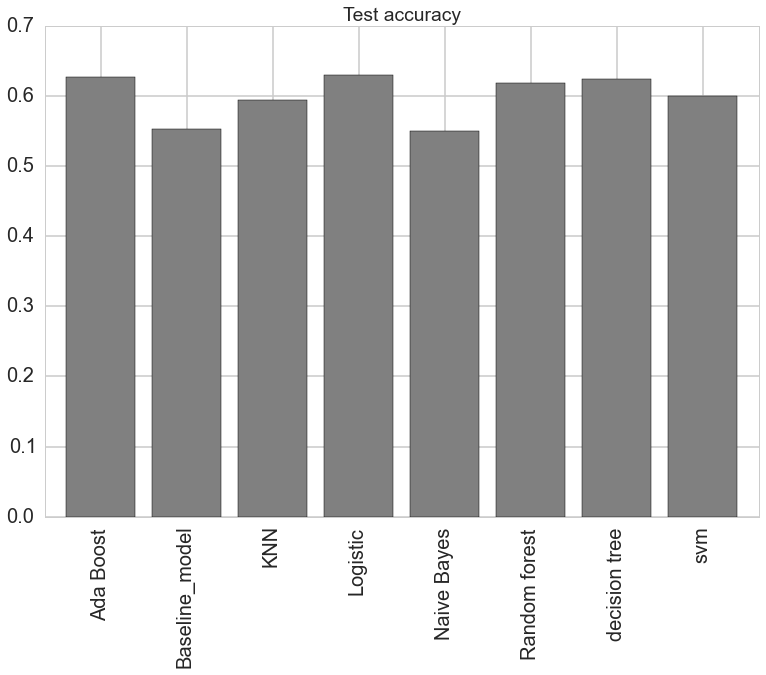

In [343]:
#Compare training and testing accuracy
pd.Series(accuracy_dict1).plot(kind="bar",title="Test accuracy",width=0.8, color="grey",fontsize=20)

### Identify important factors determining whether a crime is severe or not based on coefficients
One of the best models is logistic regression based on lasso-based feature selection. Here we will take a look at the coefficients.

In [344]:
#Reference: hw3 (exactly the same code)
def nonzero_lasso(clf):
    featuremask=(clf.coef_ !=0.0)[0]
    return pd.DataFrame(dict(feature=total_features, coef=clf.coef_[0], abscoef=np.abs(clf.coef_[0])))[featuremask].sort('abscoef', ascending=False)
lasso_importances=nonzero_lasso(clflog)
lasso_importances.head(50)

,abscoef,coef,feature
63,2.232271,-2.232271,Location Description_DEPARTMENT STORE
78,1.124398,-1.124398,Location Description_VACANT LOT/LAND
74,1.072555,1.072555,"Location Description_SCHOOL, PUBLIC, GROUNDS"
65,0.996602,-0.996602,Location Description_GROCERY FOOD STORE
69,0.972794,0.972794,Location Description_RESIDENCE PORCH/HALLWAY
73,0.802893,0.802893,"Location Description_SCHOOL, PUBLIC, BUILDING"
76,0.673282,-0.673282,Location Description_SMALL RETAIL STORE
57,0.665302,0.665302,Location Description_APARTMENT
40,0.653687,0.653687,Timeblock_3
61,0.650251,-0.650251,Location Description_CTA PLATFORM


We can see that the most important features determining whether a crime is severe or not are all indicator variables describing the exact location of the crime (for example if it happened in a department store, it's most likely not going to be something big, and probably will be things like theft). These features are consistent with what we plot above before we set up the model.

### Summary for part 1
In this part, we compare seven different models to classify crime into severe crime and less-severe crime. Based on the ROC curve and the accuracy of the model on the test set, the best classsifiers iare the logistic regression classifier using lasso-based feature selection and Ada boost classifer. The decision tree and random forest also works well (though we can only judge their performance by accuracy instead of ROC curve). We also identified features that can best distinguished severe crime and less-severe crime.

# Part 2: Multiclass classification into crime types

As shown above, after trying many different methods, the highest accuracy we can achieve for classifying severe or not is around 0.62, which beats the baseline model 0.54 for around 10%. The reason that we cannot do better is that the response variable "severe" is set up in an abitrary manner. In reality, there won't be a clearcut difference between severe or not severe. As an improvement to the above analysis, we move down to multiclassification. The goal right now is to classify each record into specific type of crimes.

We will first clean up the data. Specifically, the response variable needs to be transformed into numpy array.

Another very important thing is that we have 25 classes of crimes. Our current computational resource does not allow us to do multiclass classfication at this scale. Therefore, as a proof of principle, we here will only pick up top four types of crimes. Let's first look at the top three types of crimes: THEFT, BATTERY, CRIMINAL DAMAGE.

In [345]:
data2=data_large.sample(60000)
data2=data2.drop(["ID","Date","Block","IUCR","Description","Ward","Community Area","FBI Code","severe"], axis=1)
data2=data2.drop(["X Coordinate","Y Coordinate","Year","Location","District","time_24hour","Date_no_time"], axis=1)
data2.head()

,Latitude,Longitude,Primary Type_ARSON,Primary Type_ASSAULT,Primary Type_BATTERY,Primary Type_BURGLARY,Primary Type_CRIM SEXUAL ASSAULT,Primary Type_CRIMINAL DAMAGE,Primary Type_CRIMINAL TRESPASS,Primary Type_DECEPTIVE PRACTICE,Primary Type_GAMBLING,Primary Type_HOMICIDE,Primary Type_INTERFERENCE WITH PUBLIC OFFICER,Primary Type_INTIMIDATION,Primary Type_KIDNAPPING,Primary Type_LIQUOR LAW VIOLATION,Primary Type_MOTOR VEHICLE THEFT,Primary Type_NARCOTICS,Primary Type_OFFENSE INVOLVING CHILDREN,Primary Type_PROSTITUTION,Primary Type_PUBLIC PEACE VIOLATION,Primary Type_ROBBERY,Primary Type_SEX OFFENSE,Primary Type_STALKING,Primary Type_THEFT,Primary Type_WEAPONS VIOLATION,District_D1.0,District_D10.0,District_D11.0,District_D12.0,District_D14.0,District_D15.0,District_D16.0,District_D17.0,District_D18.0,District_D19.0,District_D2.0,District_D20.0,District_D22.0,District_D24.0,District_D25.0,District_D3.0,District_D4.0,District_D5.0,District_D6.0,District_D7.0,District_D8.0,District_D9.0,Primary Type,Timeblock_0,...,Timeblock_6,Timeblock_9,Weekday_Friday,Weekday_Monday,Weekday_Saturday,Weekday_Sunday,Weekday_Thursday,Weekday_Tuesday,Weekday_Wednesday,Precipitation,TMAX,TMIN,WT01,WT05,WT02,WT08,WT03,WT10,closest_station,House_crowded,House_below_poverty,Unemployed,Without_high_school,Under18_over64,Income,Hardship,Location Description_ALLEY,Location Description_APARTMENT,Location Description_BAR OR TAVERN,Location Description_COMMERCIAL / BUSINESS OFFICE,Location Description_CTA BUS,Location Description_CTA PLATFORM,Location Description_CTA TRAIN,Location Description_DEPARTMENT STORE,Location Description_GAS STATION,Location Description_GROCERY FOOD STORE,Location Description_PARK PROPERTY,Location Description_PARKING LOT/GARAGE(NON.RESID.),Location Description_RESIDENCE,Location Description_RESIDENCE PORCH/HALLWAY,Location Description_RESIDENCE-GARAGE,Location Description_RESIDENTIAL YARD (FRONT/BACK),Location Description_RESTAURANT,"Location Description_SCHOOL, PUBLIC, BUILDING","Location Description_SCHOOL, PUBLIC, GROUNDS",Location Description_SIDEWALK,Location Description_SMALL RETAIL STORE,Location Description_STREET,Location Description_VACANT LOT/LAND,Location Description_VEHICLE NON-COMMERCIAL
722908,41.854355,-87.712265,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,BATTERY,0,...,0,0,0,1,0,0,0,0,0,0,15.6,2.2,0,0,0,0,0,0,0.242412,7.4,43.1,21.2,27.6,42.7,12034,87,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
990672,41.769075,-87.625613,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,ASSAULT,1,...,0,0,0,0,0,0,0,1,0,0,18.9,3.9,0,0,0,0,0,0,1.038433,3.6,29.6,23.0,16.5,41.0,17285,66,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
159071,41.705118,-87.715978,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,ASSAULT,0,...,0,0,0,0,0,0,0,1,0,0,-5.5,-11.6,0,0,0,0,0,0,2.611126,1.0,3.4,8.7,4.3,36.8,34381,16,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
246977,41.691152,-87.533012,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,ASSAULT,0,...,0,0,0,0,0,1,0,0,0,0,19.4,7.8,0,0,0,0,0,0,2.154654,6.8,19.2,12.1,31.9,42.8,17104,64,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
701983,41.975686,-87.788019,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,ASSAULT,0,...,1,0,0,1,0,0,0,0,0,0,6.1,0.6,0,0,0,0,0,0,1.122218,2.0,5.4,9.0,11.5,39.5,32875,21,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [346]:
print data2.shape
data2["Crime_interested"]=data2["Primary Type_THEFT"]+data2["Primary Type_BATTERY"]+data2["Primary Type_NARCOTICS"]+data2["Primary Type_CRIMINAL DAMAGE"]
#only maintain the four specific crime types we are interested in classifying
data2=data2[data2["Crime_interested"]==1]
print data2.shape
data2.head()

(60000, 105)
(39487, 106)


,Latitude,Longitude,Primary Type_ARSON,Primary Type_ASSAULT,Primary Type_BATTERY,Primary Type_BURGLARY,Primary Type_CRIM SEXUAL ASSAULT,Primary Type_CRIMINAL DAMAGE,Primary Type_CRIMINAL TRESPASS,Primary Type_DECEPTIVE PRACTICE,Primary Type_GAMBLING,Primary Type_HOMICIDE,Primary Type_INTERFERENCE WITH PUBLIC OFFICER,Primary Type_INTIMIDATION,Primary Type_KIDNAPPING,Primary Type_LIQUOR LAW VIOLATION,Primary Type_MOTOR VEHICLE THEFT,Primary Type_NARCOTICS,Primary Type_OFFENSE INVOLVING CHILDREN,Primary Type_PROSTITUTION,Primary Type_PUBLIC PEACE VIOLATION,Primary Type_ROBBERY,Primary Type_SEX OFFENSE,Primary Type_STALKING,Primary Type_THEFT,Primary Type_WEAPONS VIOLATION,District_D1.0,District_D10.0,District_D11.0,District_D12.0,District_D14.0,District_D15.0,District_D16.0,District_D17.0,District_D18.0,District_D19.0,District_D2.0,District_D20.0,District_D22.0,District_D24.0,District_D25.0,District_D3.0,District_D4.0,District_D5.0,District_D6.0,District_D7.0,District_D8.0,District_D9.0,Primary Type,Timeblock_0,...,Timeblock_9,Weekday_Friday,Weekday_Monday,Weekday_Saturday,Weekday_Sunday,Weekday_Thursday,Weekday_Tuesday,Weekday_Wednesday,Precipitation,TMAX,TMIN,WT01,WT05,WT02,WT08,WT03,WT10,closest_station,House_crowded,House_below_poverty,Unemployed,Without_high_school,Under18_over64,Income,Hardship,Location Description_ALLEY,Location Description_APARTMENT,Location Description_BAR OR TAVERN,Location Description_COMMERCIAL / BUSINESS OFFICE,Location Description_CTA BUS,Location Description_CTA PLATFORM,Location Description_CTA TRAIN,Location Description_DEPARTMENT STORE,Location Description_GAS STATION,Location Description_GROCERY FOOD STORE,Location Description_PARK PROPERTY,Location Description_PARKING LOT/GARAGE(NON.RESID.),Location Description_RESIDENCE,Location Description_RESIDENCE PORCH/HALLWAY,Location Description_RESIDENCE-GARAGE,Location Description_RESIDENTIAL YARD (FRONT/BACK),Location Description_RESTAURANT,"Location Description_SCHOOL, PUBLIC, BUILDING","Location Description_SCHOOL, PUBLIC, GROUNDS",Location Description_SIDEWALK,Location Description_SMALL RETAIL STORE,Location Description_STREET,Location Description_VACANT LOT/LAND,Location Description_VEHICLE NON-COMMERCIAL,Crime_interested
722908,41.854355,-87.712265,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,BATTERY,0,...,0,0,1,0,0,0,0,0,0,15.6,2.2,0,0,0,0,0,0,0.242412,7.4,43.1,21.2,27.6,42.7,12034,87,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
391382,41.975421,-87.728430,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NARCOTICS,0,...,0,0,0,1,0,0,0,0,51,0.0,-4.9,1,0,0,0,0,0,0.638823,3.9,13.2,9.9,14.4,39.0,26576,33,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1
657564,41.942966,-87.768945,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,THEFT,0,...,0,0,1,0,0,0,0,0,0,3.9,-6.6,1,0,0,1,0,0,1.742207,4.1,11.6,12.6,19.3,34.0,24336,35,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
583579,41.876716,-87.745290,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,THEFT,0,...,0,0,1,0,0,0,0,0,0,23.3,11.1,1,0,0,1,0,0,1.203477,6.3,28.6,22.6,24.4,37.9,15957,73,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
946469,41.783652,-87.607112,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,CRIMINAL DAMAGE,0,...,0,0,0,0,0,1,0,0,0,8.9,0.0,0,0,0,0,0,0,1.151215,2.9,30.7,23.4,16.5,36.1,18672,58,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1


In [347]:
def get_categorical_integer(row):
    if row=="THEFT":
        return int(0)
    elif row=="BATTERY":
        return int(1)
    elif row=="CRIMINAL DAMAGE":
        return int(2)
    elif row=="NARCOTICS":
        return int(3)

#Assign each of the crime type an integer identifier. We will input these integer identifier directly for the algorithms below.
data2["category"]=data2["Primary Type"].apply(get_categorical_integer)

In [348]:
#Previously we dropped rows that are not in the four types, which mess up the integer index of the dataframe
#here we reset the integer index. This is required for the mask to work.
data2 = data2.reset_index(drop=True)
data2.head()

,Latitude,Longitude,Primary Type_ARSON,Primary Type_ASSAULT,Primary Type_BATTERY,Primary Type_BURGLARY,Primary Type_CRIM SEXUAL ASSAULT,Primary Type_CRIMINAL DAMAGE,Primary Type_CRIMINAL TRESPASS,Primary Type_DECEPTIVE PRACTICE,Primary Type_GAMBLING,Primary Type_HOMICIDE,Primary Type_INTERFERENCE WITH PUBLIC OFFICER,Primary Type_INTIMIDATION,Primary Type_KIDNAPPING,Primary Type_LIQUOR LAW VIOLATION,Primary Type_MOTOR VEHICLE THEFT,Primary Type_NARCOTICS,Primary Type_OFFENSE INVOLVING CHILDREN,Primary Type_PROSTITUTION,Primary Type_PUBLIC PEACE VIOLATION,Primary Type_ROBBERY,Primary Type_SEX OFFENSE,Primary Type_STALKING,Primary Type_THEFT,Primary Type_WEAPONS VIOLATION,District_D1.0,District_D10.0,District_D11.0,District_D12.0,District_D14.0,District_D15.0,District_D16.0,District_D17.0,District_D18.0,District_D19.0,District_D2.0,District_D20.0,District_D22.0,District_D24.0,District_D25.0,District_D3.0,District_D4.0,District_D5.0,District_D6.0,District_D7.0,District_D8.0,District_D9.0,Primary Type,Timeblock_0,...,Weekday_Friday,Weekday_Monday,Weekday_Saturday,Weekday_Sunday,Weekday_Thursday,Weekday_Tuesday,Weekday_Wednesday,Precipitation,TMAX,TMIN,WT01,WT05,WT02,WT08,WT03,WT10,closest_station,House_crowded,House_below_poverty,Unemployed,Without_high_school,Under18_over64,Income,Hardship,Location Description_ALLEY,Location Description_APARTMENT,Location Description_BAR OR TAVERN,Location Description_COMMERCIAL / BUSINESS OFFICE,Location Description_CTA BUS,Location Description_CTA PLATFORM,Location Description_CTA TRAIN,Location Description_DEPARTMENT STORE,Location Description_GAS STATION,Location Description_GROCERY FOOD STORE,Location Description_PARK PROPERTY,Location Description_PARKING LOT/GARAGE(NON.RESID.),Location Description_RESIDENCE,Location Description_RESIDENCE PORCH/HALLWAY,Location Description_RESIDENCE-GARAGE,Location Description_RESIDENTIAL YARD (FRONT/BACK),Location Description_RESTAURANT,"Location Description_SCHOOL, PUBLIC, BUILDING","Location Description_SCHOOL, PUBLIC, GROUNDS",Location Description_SIDEWALK,Location Description_SMALL RETAIL STORE,Location Description_STREET,Location Description_VACANT LOT/LAND,Location Description_VEHICLE NON-COMMERCIAL,Crime_interested,category
0,41.854355,-87.712265,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,BATTERY,0,...,0,1,0,0,0,0,0,0,15.6,2.2,0,0,0,0,0,0,0.242412,7.4,43.1,21.2,27.6,42.7,12034,87,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1
1,41.975421,-87.728430,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NARCOTICS,0,...,0,0,1,0,0,0,0,51,0.0,-4.9,1,0,0,0,0,0,0.638823,3.9,13.2,9.9,14.4,39.0,26576,33,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,3
2,41.942966,-87.768945,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,THEFT,0,...,0,1,0,0,0,0,0,0,3.9,-6.6,1,0,0,1,0,0,1.742207,4.1,11.6,12.6,19.3,34.0,24336,35,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
3,41.876716,-87.745290,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,THEFT,0,...,0,1,0,0,0,0,0,0,23.3,11.1,1,0,0,1,0,0,1.203477,6.3,28.6,22.6,24.4,37.9,15957,73,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
4,41.783652,-87.607112,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,CRIMINAL DAMAGE,0,...,0,0,0,0,1,0,0,0,8.9,0.0,0,0,0,0,0,0,1.151215,2.9,30.7,23.4,16.5,36.1,18672,58,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,2


In [349]:
def do_classify2(clf, parameters, indf, featurenames,targetname, mask, score_func=None, n_folds=5):
    subdf=indf[featurenames]
    X=subdf.values
#y will be an array with integer values for different categories (0, 1, 2, 3...)
    y=indf[targetname]
    Xtrain, Xtest, ytrain, ytest = X[mask], X[~mask], y[mask], y[~mask]
    if parameters:
        clf = cv_optimize(clf, parameters, Xtrain, ytrain, n_folds=n_folds, score_func=score_func)
    clf=clf.fit(Xtrain, ytrain)
    training_accuracy = clf.score(Xtrain, ytrain)
    test_accuracy = clf.score(Xtest, ytest)
    print "Training accuracy: %0.2f" % (training_accuracy)
    print "Test accuracy:     %0.2f" % (test_accuracy)
    confmatrix=confusion_matrix(ytest, clf.predict(Xtest))
    print confmatrix
    print clf
    return clf, Xtrain, ytrain, Xtest, ytest, training_accuracy, test_accuracy

In [350]:
mask=np.ones(data2.shape[0], dtype='int')
itrain, itest = train_test_split(xrange(data2.shape[0]), train_size=0.7)
mask[itrain]=1
mask[itest]=0
mask=(mask==1)

In [351]:
#from sklearn.preprocessing import StandardScaler
#Standardize training set
data2.loc[mask,STANDARDIZABLE]=StandardScaler().fit_transform(data2.loc[mask,STANDARDIZABLE])
#Standardize test set
data2.loc[~mask,STANDARDIZABLE]=StandardScaler().fit_transform(data2.loc[~mask,STANDARDIZABLE])
data2.head()

,Latitude,Longitude,Primary Type_ARSON,Primary Type_ASSAULT,Primary Type_BATTERY,Primary Type_BURGLARY,Primary Type_CRIM SEXUAL ASSAULT,Primary Type_CRIMINAL DAMAGE,Primary Type_CRIMINAL TRESPASS,Primary Type_DECEPTIVE PRACTICE,Primary Type_GAMBLING,Primary Type_HOMICIDE,Primary Type_INTERFERENCE WITH PUBLIC OFFICER,Primary Type_INTIMIDATION,Primary Type_KIDNAPPING,Primary Type_LIQUOR LAW VIOLATION,Primary Type_MOTOR VEHICLE THEFT,Primary Type_NARCOTICS,Primary Type_OFFENSE INVOLVING CHILDREN,Primary Type_PROSTITUTION,Primary Type_PUBLIC PEACE VIOLATION,Primary Type_ROBBERY,Primary Type_SEX OFFENSE,Primary Type_STALKING,Primary Type_THEFT,Primary Type_WEAPONS VIOLATION,District_D1.0,District_D10.0,District_D11.0,District_D12.0,District_D14.0,District_D15.0,District_D16.0,District_D17.0,District_D18.0,District_D19.0,District_D2.0,District_D20.0,District_D22.0,District_D24.0,District_D25.0,District_D3.0,District_D4.0,District_D5.0,District_D6.0,District_D7.0,District_D8.0,District_D9.0,Primary Type,Timeblock_0,...,Weekday_Friday,Weekday_Monday,Weekday_Saturday,Weekday_Sunday,Weekday_Thursday,Weekday_Tuesday,Weekday_Wednesday,Precipitation,TMAX,TMIN,WT01,WT05,WT02,WT08,WT03,WT10,closest_station,House_crowded,House_below_poverty,Unemployed,Without_high_school,Under18_over64,Income,Hardship,Location Description_ALLEY,Location Description_APARTMENT,Location Description_BAR OR TAVERN,Location Description_COMMERCIAL / BUSINESS OFFICE,Location Description_CTA BUS,Location Description_CTA PLATFORM,Location Description_CTA TRAIN,Location Description_DEPARTMENT STORE,Location Description_GAS STATION,Location Description_GROCERY FOOD STORE,Location Description_PARK PROPERTY,Location Description_PARKING LOT/GARAGE(NON.RESID.),Location Description_RESIDENCE,Location Description_RESIDENCE PORCH/HALLWAY,Location Description_RESIDENCE-GARAGE,Location Description_RESIDENTIAL YARD (FRONT/BACK),Location Description_RESTAURANT,"Location Description_SCHOOL, PUBLIC, BUILDING","Location Description_SCHOOL, PUBLIC, GROUNDS",Location Description_SIDEWALK,Location Description_SMALL RETAIL STORE,Location Description_STREET,Location Description_VACANT LOT/LAND,Location Description_VEHICLE NON-COMMERCIAL,Crime_interested,category
0,0.151211,-0.688499,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,BATTERY,0,...,0,1,0,0,0,0,0,-0.077910,-0.119056,-0.535430,0,0,0,0,0,0,-1.525430,0.504682,1.768624,0.523458,0.543380,0.951938,-0.717691,1.060349,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1
1,1.574251,-0.978019,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NARCOTICS,0,...,0,0,1,0,0,0,0,0.115888,-1.449194,-1.196816,1,0,0,0,0,0,-0.920589,-0.406002,-1.155632,-0.933841,-0.581522,0.482301,0.063778,-0.740028,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,3
2,1.192632,-1.679036,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,THEFT,0,...,0,1,0,0,0,0,0,-0.040372,-1.115582,-1.357372,1,0,0,1,0,0,0.810568,-0.353291,-1.311301,-0.583565,-0.153818,-0.137398,-0.057300,-0.672975,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
3,0.413652,-1.269746,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,THEFT,0,...,0,1,0,0,0,0,0,-0.040372,0.543924,0.314301,1,0,0,1,0,0,-0.034674,0.226531,0.342680,0.713750,0.291343,0.345967,-0.510210,0.601022,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
4,-0.680620,1.121083,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,CRIMINAL DAMAGE,0,...,0,0,0,0,1,0,0,-0.040372,-0.687874,-0.734036,0,0,0,0,0,0,-0.116670,-0.669558,0.546995,0.817536,-0.398220,0.122875,-0.363456,0.098129,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,2


### Model 0: Base-line model
We know that theft is the most common type of crime. What if we predict every single crime record as theft? This will be our baseline model. For whatever algorithms we use, the accuracy should be higher than this base line model (which is around 0.33).

In [352]:
print float(len(data2[data2["category"]==0]))/len(data2)
train_theft_percent=float(sum(data2["Primary Type_THEFT"].values[mask]))/len(data2["Primary Type_THEFT"].values[mask])
test_theft_percent=float(sum(data2["Primary Type_THEFT"].values[~mask]))/len(data2["Primary Type_THEFT"].values[~mask])

print train_theft_percent
print test_theft_percent

accuracy_multi_train={}
accuracy_multi_test={}
accuracy_multi_train["Baseline model"]=train_theft_percent
accuracy_multi_test["Baseline model"]=test_theft_percent

0.343733380606
0.34497105644
0.340845783743


### Model 1: Decision tree for multiclass
From the result below, we can see that this model beats the baseline model for around 15%, which is already very good performance.

In [353]:
from sklearn.tree import DecisionTreeClassifier
clfdt_multi=DecisionTreeClassifier()
clfdt_multi, Xtrain, ytrain, Xtest, ytest, training_accuracy, test_accuracy=do_classify2(clfdt_multi, {"max_depth":range(1,20,2)}, data2, total_features, "category", mask=mask)
accuracy_multi_train["Decision tree multiclass"]=training_accuracy
accuracy_multi_test["Decision tree multiclass"]=test_accuracy

Training accuracy: 0.57
Test accuracy:     0.50
[[2684  693  225  436]
 [ 978 1782  157  651]
 [ 905  607  259  344]
 [ 539  314   93 1180]]
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=11,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            random_state=None, splitter='best')


### Model 2: Random forest for multiclass

In [354]:
from sklearn.ensemble import RandomForestClassifier
randfmulti=RandomForestClassifier()
randfmulti, Xtrain, ytrain, Xtest, ytest, training_accuracy, test_accuracy=do_classify2(randfmulti, {"n_estimators":[10, 20, 30, 40, 100]}, data2, total_features, "category", mask=mask)
accuracy_multi_train["Random forest multiclass"]=training_accuracy
accuracy_multi_test["Random forest multiclass"]=test_accuracy

Training accuracy: 1.00
Test accuracy:     0.51
[[2573  825  326  314]
 [ 827 2003  266  472]
 [ 878  676  371  190]
 [ 433  436  169 1088]]
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


### Model 3: Ada Boost for multiclass

In [355]:
from sklearn.ensemble import AdaBoostClassifier
adamulti=AdaBoostClassifier()
adamulti, Xtrain, ytrain, Xtest, ytest, training_accuracy, test_accuracy=do_classify2(adamulti, {"n_estimators":[10, 20, 30, 40, 100]}, data2, total_features, "category", mask=mask)
accuracy_multi_train["Ada Boost multiclass"]=training_accuracy
accuracy_multi_test["Ada Boost multiclass"]=test_accuracy

Training accuracy: 0.53
Test accuracy:     0.52
[[2538  860  305  335]
 [ 707 2112  196  553]
 [ 831  688  372  224]
 [ 419  373  179 1155]]
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=100, random_state=None)


### Model 4: Logistic regression for multiclass
In sklearn, some algorithms are intrinsically multiclass, while some others, for example logistic regression, will need some slight modification in parameter setting.

In [356]:
from sklearn.linear_model import LogisticRegression
clflogmulti=LogisticRegression(penalty="l2",multi_class='multinomial',solver="newton-cg",max_iter=100)
clflogmulti, Xtrain, ytrain, Xtest, ytest, training_accuracy, test_accuracy=do_classify2(clflogmulti, {"C": [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]}, data2, total_features, 'category', mask=mask)
accuracy_multi_train["Logistic - newton cg"]=training_accuracy
accuracy_multi_test["Logistic - newton cg"]=test_accuracy

Training accuracy: 0.54
Test accuracy:     0.53
[[2619  875  233  311]
 [ 728 2179  120  541]
 [ 889  706  292  228]
 [ 484  344  141 1157]]
LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          penalty='l2', random_state=None, solver='newton-cg', tol=0.0001,
          verbose=0)


We can also use "lbfgs" as a solver, but seems to be similar.

In [357]:
from sklearn.linear_model import LogisticRegression
clflogmulti2 = LogisticRegression(penalty="l2",multi_class='multinomial',solver="lbfgs",max_iter=400)
clflogmulti2, Xtrain, ytrain, Xtest, ytest, training_accuracy, test_accuracy=do_classify2(clflogmulti2, {"C": [0.01, 0.1, 1.0, 10.0]}, data2, total_features, 'category', mask=mask)
accuracy_multi_train["Logistic - lbfgs"]=training_accuracy
accuracy_multi_test["Logistic - lbfgs"]=test_accuracy

Training accuracy: 0.54
Test accuracy:     0.53
[[2619  875  233  311]
 [ 728 2179  120  541]
 [ 889  706  292  228]
 [ 484  344  141 1157]]
LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=400, multi_class='multinomial',
          penalty='l2', random_state=None, solver='lbfgs', tol=0.0001,
          verbose=0)


Since one the best model is the clflogmulti based on newton-cg, we can take a look at the coefficients of this model to have an idea what are the most important features for classifying each record into specific crimes.

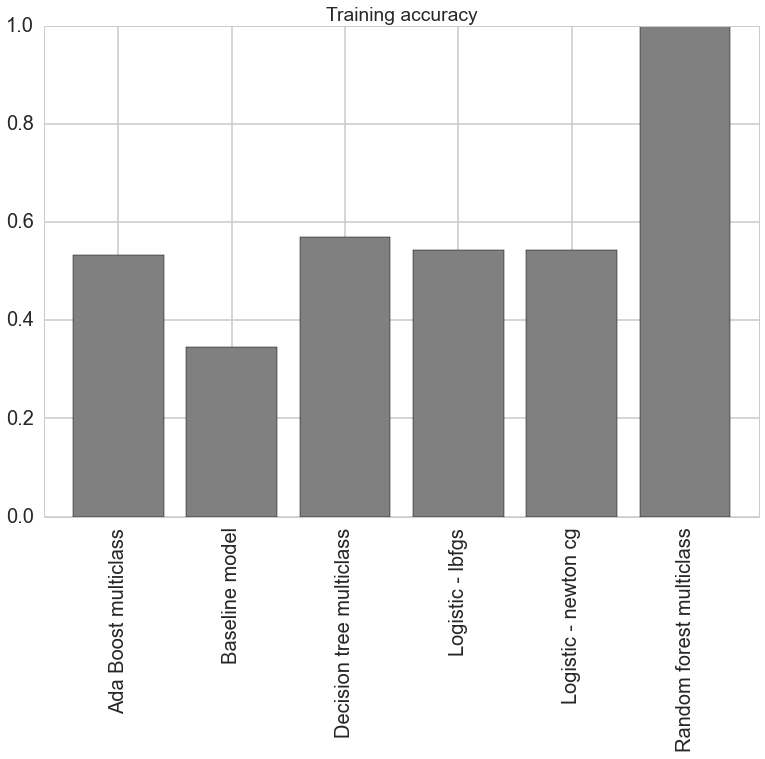

In [358]:
#Compare training and testing accuracy
pd.Series(accuracy_multi_train).plot(kind="bar",title="Training accuracy",width=0.8,color="grey", fontsize=20)

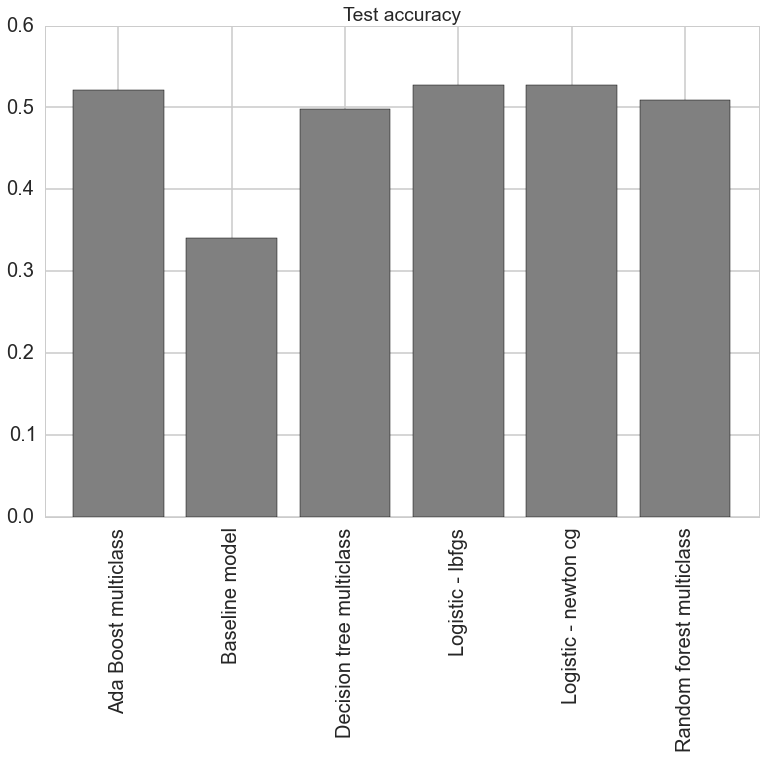

In [359]:
#Compare training and testing accuracy
pd.Series(accuracy_multi_test).plot(kind="bar",title="Test accuracy",width=0.8,color="grey", fontsize=20)

### Summary for part 2:
In this part, we tested various models for multiclass classification. To reduce the computational effort, we tried to classify crime records into four major types of crimes: theft, battery, criminal damage and narcotics. Our result suggests that all our models outbeat the baseline model for 15% to 20% and reach a final accuracy around 50%. We also identified features important for multiclass classification.

# Part 3: other ways to assess multiclass classification

As shown above, it may be difficult to perfectly classify each individual crime record (the best we achieve for the four-crime-type situation is around 50%), because there is always some intrinsic randomness for crimes. For example, if you are at a bad neighbourhood at a wrong time, it is likely that something violent will happen around you, but it might be difficult to say it is going to be a criminal damage or a battery.

As a result, instead of reporting the crime that most likely will happen, we can report two or more most possible types of crimes, and judge our accuracy based on that.

To do this, we can utilize the get_proba feature of sklearn models to obtain the probability for each of the labels. Instead of reporting only one most likely type of crime, we report the two most likely crimes. The base line model without implementing anything will be to classify every single record as theft and battery, the two most common types of crimes.

In [360]:
#What is the accuracy for two-type prediction for a baseline model?
total_predict=len(ytest)
correct_predict=0
for i in range(0,total_predict):
    if ((ytest.iloc[i]==0) | (ytest.iloc[i]==1)):
        correct_predict += 1
    if ytest.iloc[i]==0:
        baseline_accuracy += 1
print float(correct_predict)/total_predict

0.642019076559


In [361]:
#Reference: http://stackoverflow.com/questions/6910641/how-to-get-indices-of-n-maximum-values-in-a-numpy-array
def accuracy_two_type(est, Xtest, ytest):
    probs=est.predict_proba(Xtest)
    correct_predict=0
    total_predict=len(ytest)
#For each line (a prediction with four probabilities for the four categories), we obtain the two most likely classes
#We checked whether the actual observation is in one of the two predictions
#If so, we call the result for this record of crime accurate
    for i in range(0,total_predict):
#This will return the column index of the two largest probabilities, which directly corresponds to type of crime
        ind=np.argpartition(probs[i,],-2)[-2:]
        if ytest.iloc[i] in ind:
            correct_predict+=1
        i+=1
    return float(correct_predict)/total_predict

In [362]:
print accuracy_two_type(clflogmulti, Xtest, ytest)
print accuracy_two_type(clflogmulti2, Xtest, ytest)

0.775977040601
0.775977040601


We can see that our model of selection (clflogmulti, logistic regression using newton cg as the solver) can achieve an accuracy of 80% when reporting the two most possible crime types, which beat the baseline model for around 15%.

Finally, let's examine what features are the most important ones.

In [363]:
lasso_importances_multi=nonzero_lasso(clflogmulti)
lasso_importances_multi.head(50)

,abscoef,coef,feature
63,1.845706,1.845706,Location Description_DEPARTMENT STORE
65,1.241523,1.241523,Location Description_GROCERY FOOD STORE
56,1.140558,-1.140558,Location Description_ALLEY
75,1.054351,-1.054351,Location Description_SIDEWALK
76,1.037042,1.037042,Location Description_SMALL RETAIL STORE
62,0.672760,0.672760,Location Description_CTA TRAIN
57,0.657034,-0.657034,Location Description_APARTMENT
74,0.592489,-0.592489,"Location Description_SCHOOL, PUBLIC, GROUNDS"
69,0.492264,-0.492264,Location Description_RESIDENCE PORCH/HALLWAY
68,0.401545,-0.401545,Location Description_RESIDENCE


### Summary for part 3:
In this part, we examined whether our classifer can accurately report the two most possible types of crime given time, location and other information derived from time and location. In this case, the base line model (classifying everything as theft and battery) works ok, since theft and battery accounts for more than 60% of the total crime. In this case, our classifier based on logistic regression can reach an accuracy closed to 80%. 